In [24]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils 
import seaborn as sns
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras

In [16]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
data_dir =  'D:/Vishwa_clg/Brain Tumor/Dataset'
dict_img = {}
for dir in os.listdir(data_dir):
  dict_img[dir] = len(os.listdir(os.path.join(data_dir, dir)))
dict_img

{'no': 2500, 'yes': 2764}

In [17]:
height, width = 224, 224
batch_size=64
def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            data_dir,
            batch_size=batch_size,
            subset="training",
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'no': 0., 'yes': 1.}
            )
    val_ds = datagen.flow_from_directory(
              data_dir,
              subset="validation",
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
            classes={'no': 0., 'yes': 1.}
            )
    return train_ds, val_ds

train_ds, val_ds = image_generator(height, width)

total_image = np.concatenate([train_ds.labels,val_ds.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})

Found 4212 images belonging to 2 classes.
Found 1052 images belonging to 2 classes.


 {'No_brain_tumor_cases': 2500, 'brain_tumor_cases': 2764}


In [18]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):
    
    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [21]:
# inception v3
height = 299
width = 299

train_ds, val_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 4212 images belonging to 2 classes.
Found 1052 images belonging to 2 classes.
87910968/87910968 [==============================] - 36s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
# train inception v3
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
66/66 [==============================] - ETA: 0s - loss: 0.7975 - acc: 0.9091
Epoch 1: acc improved from -inf to 0.90907, saving model to model\inceptionv3_best.h5
66/66 [==============================] - 401s 6s/step - loss: 0.7975 - acc: 0.9091 - val_loss: 0.0396 - val_acc: 0.9886
Epoch 2/25
66/66 [==============================] - ETA: 0s - loss: 0.0256 - acc: 0.9924
Epoch 2: acc improved from 0.90907 to 0.99240, saving model to model\inceptionv3_best.h5
66/66 [==============================] - 482s 7s/step - loss: 0.0256 - acc: 0.9924 - val_loss: 0.0108 - val_acc: 0.9962
Epoch 3/25
66/66 [==============================] - ETA: 0s - loss: 0.0037 - acc: 0.9993
Epoch 3: acc improved from 0.99240 to 0.99929, saving model to model\inceptionv3_best.h5
66/66 [==============================] - 471s 7s/step - loss: 0.0037 - acc: 0.9993 - val_loss: 0.0114 - val_acc: 0.9962
Epoch 4/25
66/66 [==============================] - ETA: 0s - loss: 9.8060e-04 - acc: 1.0000
Epoch 4: acc imp

In [25]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

17/17 [==============================] - 104s 6s/step - loss: 0.0075 - acc: 0.9981


,Train,Val
Loss,0.000267,0.007452
Acc,1.000000,0.998099


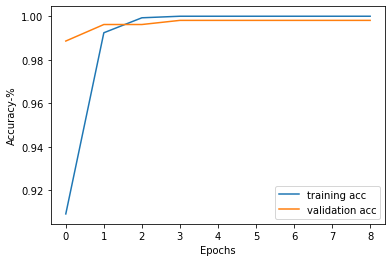

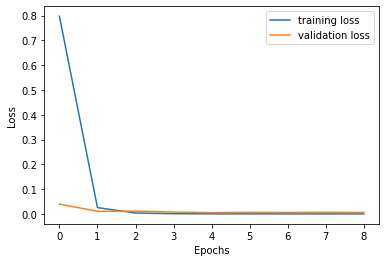

In [27]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [29]:
#Test our model on the test set
from keras.models import load_model
model = load_model('./model/inceptionv3_best.h5')
acc = model.evaluate(val_ds)[1]
print(f'The accuracy of our model is {acc}')

17/17 [==============================] - 91s 5s/step - loss: 0.0075 - acc: 0.9981
The accuracy of our model is 0.9980988502502441


In [37]:
#Try our model on a random image that it has never seen before
from tensorflow.keras.utils import img_to_array
#Choose a MRI image with tumor
path = "./test/yes/gg (1).jpg"
img_yes = load_img(path, target_size=(299,299))
img_array_yes = img_to_array(img_yes)/255
img_array_yes = np.expand_dims(img_array_yes, axis=0)
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 4s 4s/step
The MRI image has a tumor


In [38]:
#Try our model on a random image that it has never seen before
from tensorflow.keras.utils import img_to_array
#Choose a MRI image with tumor
path = "./test/no/1.jpg"
img_yes = load_img(path, target_size=(299,299))
img_array_yes = img_to_array(img_yes)/255
img_array_yes = np.expand_dims(img_array_yes, axis=0)
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 0s 144ms/step
The MRI image doesn't have a Tumor
